## Prepare imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.data import Batch,Data


DEVICE = "cuda:0"
ECT_PLOT_CONFIG = {"cmap":"bone","vmin":-0.5,"vmax":1.5}
PC_PLOT_CONFIG = {"s":10,"c":'.5'}


## Load Models and Data

In [2]:
from types import SimpleNamespace
from datasets import load_datamodule
import yaml
import json

from models.encoder import BaseModel as Encoder


def load_object(dct):
    return SimpleNamespace(**dct)

with open("./configs/config_encoder_mnist.yaml", encoding="utf-8") as stream:
    run_dict = yaml.safe_load(stream)
    encoder_config = json.loads(json.dumps(run_dict), object_hook=load_object)

dm = load_datamodule(encoder_config.data)


encoder = Encoder.load_from_checkpoint(f"./trained_models/{encoder_config.modelconfig.save_name}").to(DEVICE)



C:\Users\ernst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\ernst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.2.3


In [3]:
data_list = []
for idx in range(10):
    data_list.extend(dm.test_ds[dm.test_ds.y==idx][:1])

batch = Batch.from_data_list(data_list).to(DEVICE)

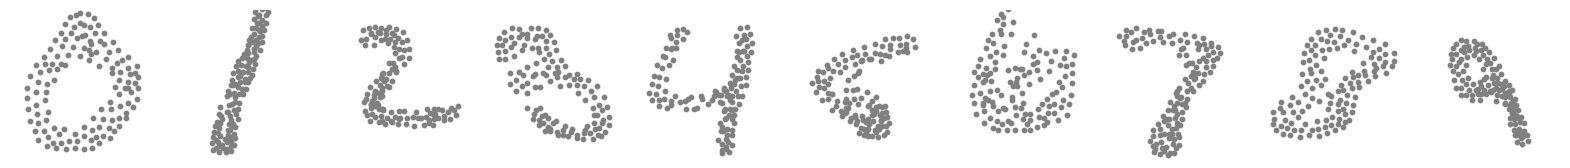

In [4]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

ect = encoder.layer(batch,batch.batch)
with torch.no_grad():
    recon_batch = encoder.model(ect.squeeze())

fig, axes = plt.subplots(
    nrows=1, ncols=10, figsize=(20,8)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)
    
for orig_pts, recon_pts,axis in zip(batch.x.view(-1,128,2),recon_batch,axes.T):
    # print(recon_pts_x.shape)
    recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = orig_pts.view(-1,2).cpu().detach().squeeze().numpy()
   
    orig_pts = rotate(orig_pts, degrees=-90)
    recon_pts = rotate(recon_pts, degrees=-90)
    
    ax = axis
    ax.scatter(recon_pts[:,0],recon_pts[:,1],**PC_PLOT_CONFIG)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)
    ax.axis("off")


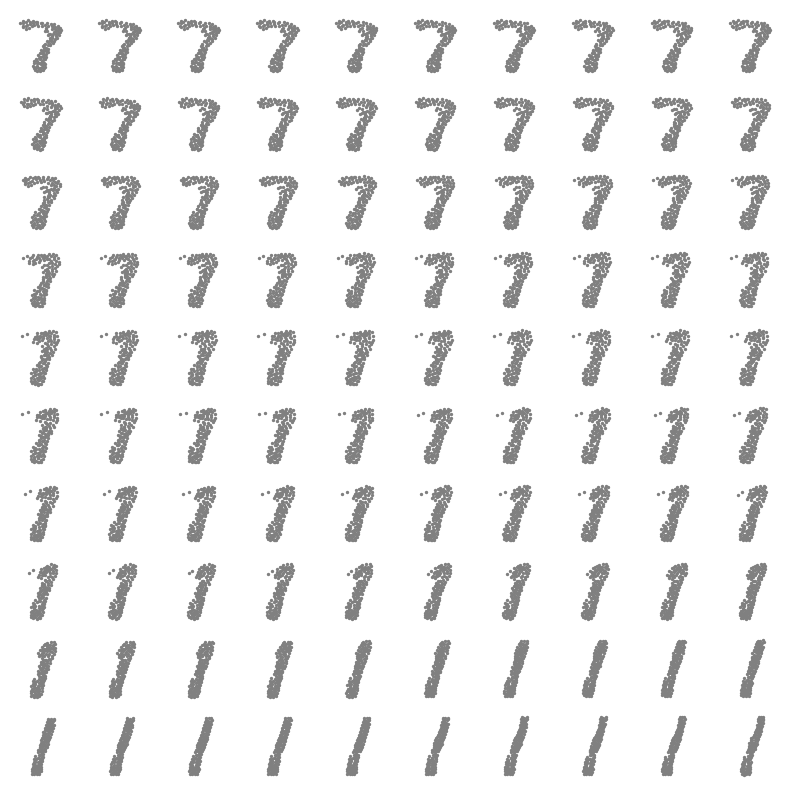

In [13]:
START = 1
END = 7
STEPS = 100
ect = encoder.layer(batch,batch.batch).unsqueeze(1)

with torch.no_grad():
    t = torch.tensor(np.linspace(0,1,STEPS,endpoint=True)).view(-1,1,1).cuda()
    ect_interp = (t * ect[START].repeat((STEPS,1,1)) + (1-t) * ect[END].repeat((STEPS,1,1))).to(torch.float32)
    ect_interp_pc = encoder(ect_interp.unsqueeze(1))

fig, axes = plt.subplots(
    nrows=10, ncols=10, figsize=(10,10)
)
# fig.subplots_adjust(wspace=0.05,hspace=0.05)

for j in range(10):
    for i in range(10):
        # print(recon_pts_x.shape)
        interp_pts = ect_interp_pc[10*j + i].view(-1,2).cpu().detach().squeeze().numpy()
        interp_pts = rotate(interp_pts, degrees=-90)
        
        ax = axes[j,i]
        ax.scatter(interp_pts[:,0],interp_pts[:,1],s=2,c='.5')
        ax.set_xlim([-1.1,1.1])
        ax.set_ylim([-1.1,1.1])
        # ax.set_aspect(1)
        ax.axis("off")

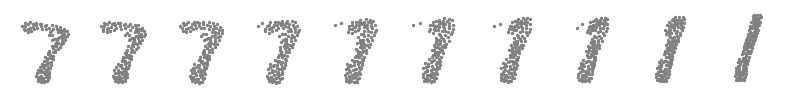

In [14]:
fig, axes = plt.subplots(
    nrows=1, ncols=10, figsize=(10,1)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for i in range(0,10):
    # print(recon_pts_x.shape)
    interp_pts = ect_interp_pc[10*i].view(-1,2).cpu().detach().squeeze().numpy()
    interp_pts = rotate(interp_pts, degrees=-90)
    
    ax = axes[i]
    ax.scatter(interp_pts[:,0],interp_pts[:,1],s=2,c='.5')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    # ax.set_aspect(1)
    ax.axis("off")

fig.savefig("./figures/img/mnist/interpolation_samples.svg",transparent=True)

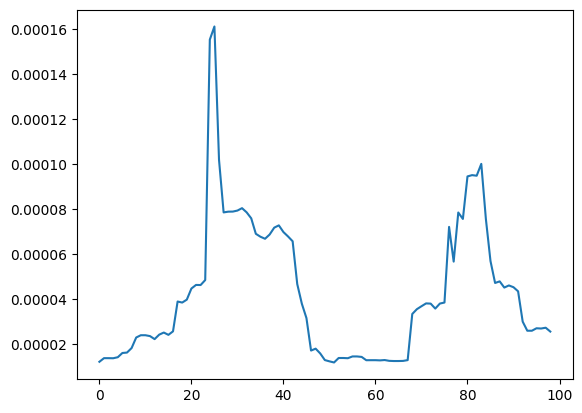

In [15]:
from kaolin.metrics.pointcloud import chamfer_distance

cd = chamfer_distance(
                torch.cat(
                    [
                       ect_interp_pc.view(100,128,2),
                        torch.zeros(size=(100, 128, 1), device="cuda:0"),
                    ],
                    dim=-1,
                ),
                torch.cat(
                    [
                        torch.roll(ect_interp_pc,shifts=-1,dims=0).view(100,128,2),
                        torch.zeros(size=(100, 128, 1), device="cuda:0"),
                    ],
                    dim=-1,
                ),
            )
plt.plot(cd[:-1].cpu().numpy())

# Plot the chamfer distance between consequtive elements in the interpolation. 

# CDT interpolation 

In [16]:
from pytranskit.optrans.continuous.cdt import CDT

def cdt_interp(ect_start, ect_end):
    N=64
    x0 = np.linspace(0, 1, N)
    I0= np.ones(x0.size)
    x=np.linspace(0, 2, N)
    num_thetas = 64
    ect = np.zeros((num_thetas,num_thetas))
    I1 = abs(ect_start) + 1e-7
    I2 = abs(ect_end) + 1e-7

    I1 = I1/I1.sum(axis=0)
    I2 = I2/I2.sum(axis=0)
    
    taus = np.linspace(0,1,100)
    cdt1 = CDT()
    inter = []

    for tau in taus: 
        for idx in range(num_thetas):
            # Compute the forward transform
            I1_hat, I1_hat_old, xtilde = cdt1.forward(x0, I0, x, I1[:,idx], rm_edge=False)
            I2_hat, I2_hat_old, xtilde = cdt1.forward(x0, I0, x, I2[:,idx], rm_edge=False)


            I_hat = ( tau ) * I1_hat + ( 1 - tau ) * I2_hat  
            I_recon = cdt1.inverse(I_hat, I0, x)

            ect[:,idx] = I_recon
            
        inter.append(ect)
        ect = np.zeros((num_thetas,num_thetas))
    return torch.tensor(np.stack(inter))

In [17]:

from layers.directions import generate_directions
from layers.ect import EctConfig, EctLayer


derlayer = EctLayer(EctConfig(num_thetas=64,bump_steps=64,device=DEVICE,ect_type="points_derivative"),
                    v = generate_directions(d=2,device=DEVICE))

cdt_batch = derlayer(batch,batch.batch,scale=100).unsqueeze(1)

cdt_start = cdt_batch[START].cpu().squeeze().detach().numpy() 
cdt_end = cdt_batch[END].cpu().squeeze().detach().numpy() 

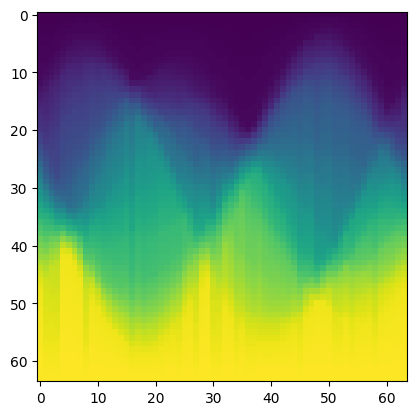

In [18]:
cdt = cdt_interp(cdt_start,cdt_end).unsqueeze(1).cumsum(axis=2).cuda().float()
plt.imshow(cdt[0].squeeze().cpu())

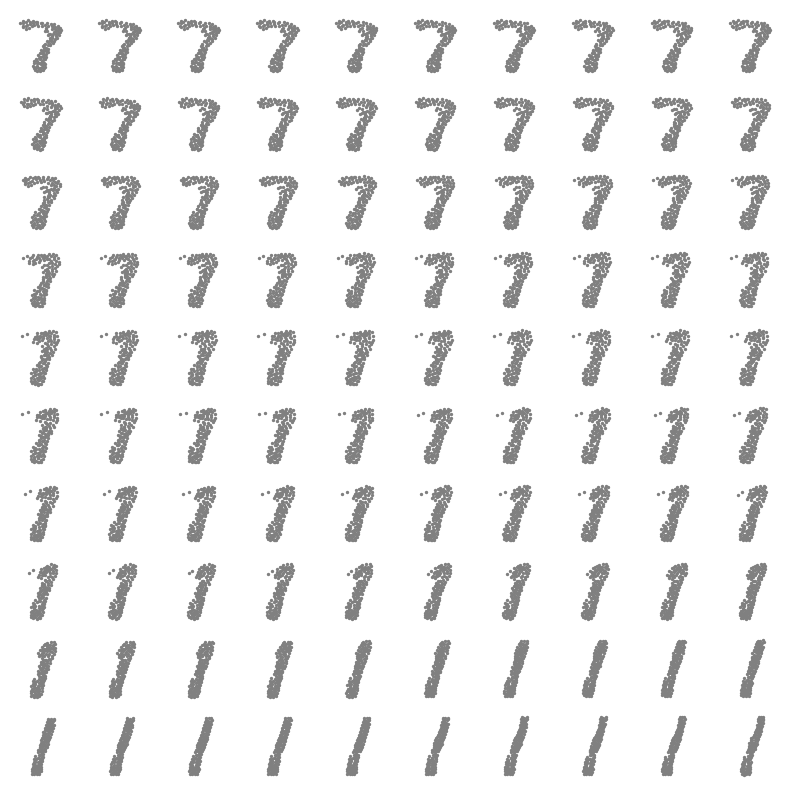

In [19]:
with torch.no_grad():
    ect_cdt_pc = encoder(cdt)

fig, axes = plt.subplots(
    nrows=10, ncols=10, figsize=(10,10)
)
# fig.subplots_adjust(wspace=0.05,hspace=0.05)

for j in range(10):
    for i in range(10):
        # print(recon_pts_x.shape)
        interp_pts = ect_interp_pc[10*j + i].view(-1,2).cpu().detach().squeeze().numpy()
        interp_pts = rotate(interp_pts, degrees=-90)
        
        ax = axes[j,i]
        ax.scatter(interp_pts[:,0],interp_pts[:,1],s=2,c='.5')
        ax.set_xlim([-1.1,1.1])
        ax.set_ylim([-1.1,1.1])
        # ax.set_aspect(1)
        ax.axis("off")

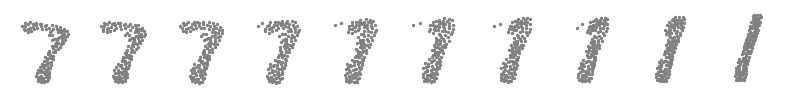

In [20]:
fig, axes = plt.subplots(
    nrows=1, ncols=10, figsize=(10,1)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for i in range(0,10):
    # print(recon_pts_x.shape)
    interp_pts = ect_interp_pc[10*i].view(-1,2).cpu().detach().squeeze().numpy()
    interp_pts = rotate(interp_pts, degrees=-90)
    
    ax = axes[i]
    ax.scatter(interp_pts[:,0],interp_pts[:,1],s=2,c='.5')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    # ax.set_aspect(1)
    ax.axis("off")

fig.savefig("./figures/img/mnist/interpolation_cdt_samples.svg",transparent=True)

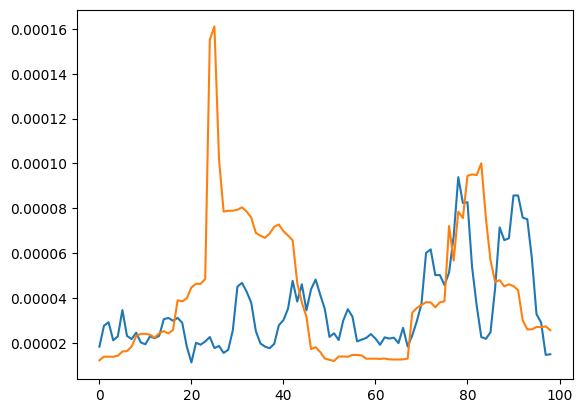

In [21]:
from kaolin.metrics.pointcloud import chamfer_distance

cd_cdt = chamfer_distance(
                torch.cat(
                    [
                       ect_cdt_pc.view(100,128,2),
                        torch.zeros(size=(100, 128, 1), device="cuda:0"),
                    ],
                    dim=-1,
                ),
                torch.cat(
                    [
                        torch.roll(ect_cdt_pc,shifts=-1,dims=0).view(100,128,2),
                        torch.zeros(size=(100, 128, 1), device="cuda:0"),
                    ],
                    dim=-1,
                ),
            )
plt.plot(cd_cdt[:-1].cpu().numpy())
plt.plot(cd[:-1].cpu().numpy())


In [22]:
entropy_ect_cdt = []
for pc in ect_cdt_pc:
    data = pc.view(-1,2).cpu().detach()
    hist = np.histogramdd(np.array(data))[0]
    hist /= hist.sum()
    hist = hist.flatten()
    hist = hist[hist.nonzero()]
    entropy_ect_cdt.append( -0.5 * np.sum(hist * np.log2(hist)))
entropy_ect_cdt = np.array(entropy_ect_cdt)


entropy_ect = []
for pc in ect_interp_pc:
    data = pc.view(-1,2).cpu().detach()
    hist = np.histogramdd(np.array(data))[0]
    hist /= hist.sum()
    hist = hist.flatten()
    hist = hist[hist.nonzero()]
    entropy_ect.append( -0.5 * np.sum(hist * np.log2(hist)))
entropy_ect = np.array(entropy_ect)

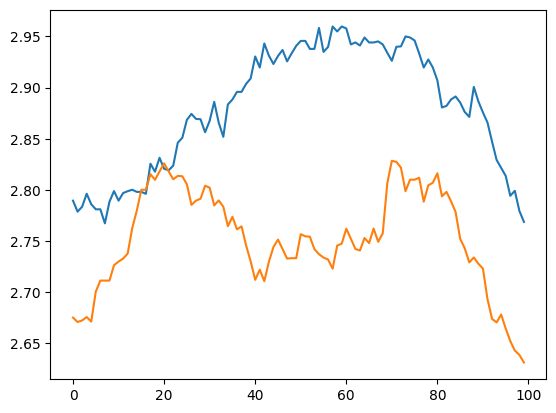

In [23]:
plt.plot(entropy_ect_cdt)
plt.plot(entropy_ect)
